Importing some useful packages

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import numpy as np
import cv2
import math
import operator
import os
from moviepy.editor import VideoFileClip
from IPython.display import HTML

Define functions that will be used in the pipeline

In [2]:
def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, top_y_vertex, lines, color=[255, 0, 0], thickness= 2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    #for line in lines:
    #    for x1,y1,x2,y2 in line:
    #        cv2.line(img, (x1, y1), (x2, y2), color, thickness)
            
    #top_y_vertex = 320  
    img_midpoint = img.shape[1]/2
    
    left_points_x  = []
    left_points_y  = []
    left_slope = []
    
    right_points_x = []
    right_points_y = []
    right_slope = []
    
    for line in lines:
        for x1,y1,x2,y2 in line:
            slope, intercept = np.polyfit((x1, x2), (y1, y2), 1)
            if .4 < np.absolute(slope) <= .85:
                if slope > 0 and x1 > img_midpoint and x2 > img_midpoint:
                    right_points_y.append(y1)
                    right_points_y.append(y2)
                    right_points_x.append(x1)
                    right_points_x.append(x2)
                    right_slope.append(slope)
                elif slope < 0 and x1 < img_midpoint and x2 < img_midpoint: 
                    left_points_y.append(y1)
                    left_points_y.append(y2)
                    left_points_x.append(x1)
                    left_points_x.append(x2)
                    left_slope.append(slope)

    left = sorted(zip(left_points_x,left_points_y), key=operator.itemgetter(1))
    right = sorted(zip(right_points_x,right_points_y), key=operator.itemgetter(1))
    
    if len(left)!= 0: 
        first_point_left = left[1] 
        last_point_left =  left[-1]
        left_avg_slope = sum(left_slope)/float(len(left_slope))
        pos_left_avg_slope = np.tan(np.pi - np.arctan(left_avg_slope))
        start_point_left_x = first_point_left[0] + (first_point_left[1]- top_y_vertex)/pos_left_avg_slope
        end_point_left_x = last_point_left[0] - (image.shape[0]-last_point_left[1])/pos_left_avg_slope
        cv2.line(img,(int(start_point_left_x),top_y_vertex),(int(end_point_left_x),image.shape[0]),(255,0,0),10) 
    
    if len(right)!= 0:
        first_point_right = right[1] 
        last_point_right = right[-1]
        right_avg_slope = sum(right_slope)/float(len(right_slope))
        start_point_right_x = first_point_right[0] - (first_point_right[1]- top_y_vertex)/right_avg_slope
        end_point_right_x = last_point_right[0] + (image.shape[0]-last_point_right[1])/right_avg_slope
        cv2.line(img,(int(start_point_right_x),top_y_vertex),(int(end_point_right_x),image.shape[0]),(255,0,0),10)
        
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    return lines

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

Pipeline of steps on a single image:

In [3]:
def process_image(image):
    
    # Parameters for Canny edge detection
    low_threshold = 50
    high_threshold = 140
    
    #End points of the polygon for Region Masking
    top_y_vertex = 320
    vertices = np.array([[(50,540),(450, top_y_vertex), (500, top_y_vertex), (920,540)]], dtype=np.int32)
    
    
    # Define the Hough transform parameters
    rho = 2 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 20     # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 40 #minimum number of pixels making up a line
    max_line_gap = 80    # maximum gap in pixels between connectable line segments
    
    # Pipeline that gives an image with lane lines a result
    gray = grayscale(image)
    blur_gray = gaussian_blur(gray, 5)
    canny_edges = canny(blur_gray, low_threshold, high_threshold)
    masked_canny_edges = region_of_interest(canny_edges,vertices)
    lines = hough_lines(masked_canny_edges, rho, theta, threshold, min_line_length, max_line_gap)
    line_image = np.zeros((image.shape[0], image.shape[1], 3), dtype=np.uint8)
    draw_lines(line_image, top_y_vertex, lines)
    result = weighted_img(line_image, image, 0.8, 1, 0)
    return result

Read all the test images from the directory and process them

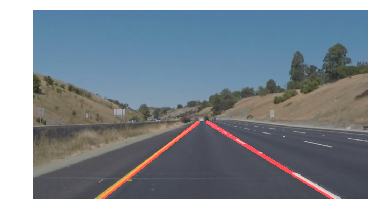

In [ ]:
list_images = os.listdir("test_images/")
len_list_images = len(list_images)
#os.mkdir('test_images_output')

for i,im in zip(range(len_list_images),list_images):
    image = mpimg.imread(os.path.join("test_images/",im)) 
    image_in = process_image(image)
    plt.axis('off')
    image_out = plt.imshow(image_in)
    plt.savefig('test_images_output/image_out_'+str(i))

Video Processing : Draw lane lines on video data

In [ ]:
white_output = 'solidWhiteRight_output.mp4'
#white_output = 'test_videos_output/solidWhiteRight.mp4'
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video solidWhiteRight_output.mp4
[MoviePy] Writing video solidWhiteRight_output.mp4


 55%|█████▍    | 121/222 [00:03<00:02, 37.90it/s]

In [ ]:
yellow_output = 'solidYellowLeft_output.mp4'
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)